<a href="https://colab.research.google.com/github/zhukuixi/d2l/blob/main/weightDecay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
!pip uninstall matplotlib
!pip install matplotlib==3.0.0
!pip install matplotlib_inline

import torch
from torch import nn
import numpy as np
from d2l import torch as d2l
from torch.utils import data


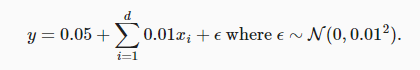

In [98]:
# 按照公式成synthetic data。为了加强过拟合的效果，我们将问题的维数增加到200， 并使用一个只包含20个样本的小训练集
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

# 从零开始实现权重衰减
- 只需将的L2平方惩罚添加到原始目标函数中即可

In [99]:
def init_params():
  w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
  b = torch.zeros(1,requires_grad=True)
  return [w,b]

def l2_penalty(w):
  return torch.sum(w.pow(2))/2

def train(lambd,num_epochs=100,lr=0.003):
  w,b = init_params()
  # 这一行很妙，实现了net只是X的function
  net = lambda X: d2l.linreg(X, w, b)
  loss = d2l.squared_loss  
  animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
  
  for epoch in range(num_epochs):
    for X,y in train_iter:
      l = loss(net(X),y) + lambd*l2_penalty(w)
      l.sum().backward()      
      d2l.sgd([w,b],lr,batch_size)
    if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
  print('w的L2范数是：', torch.norm(w).item())



忽略正则化lambda=0

w的L2范数是： 12.410638809204102


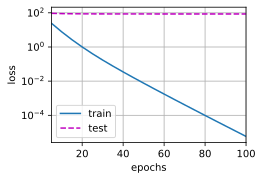

In [100]:
train(lambd=0)

使用权重衰减

w的L2范数是： 0.35659316182136536


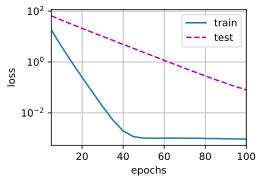

In [101]:
train(lambd=3)

# API实现
在下面的代码中，我们在**实例化优化器**时直接通过weight_decay指定weight decay超参数。 默认情况下，PyTorch同时衰减权重和偏移。 这里我们只为权重设置了weight_decay，所以偏置参数不会衰减。

In [102]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())


w的L2范数： 13.396234512329102


(1.2899144252731532e-11, 130.78049827575683)

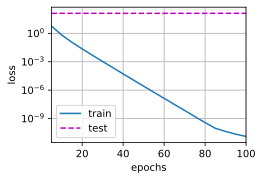

In [103]:
train_concise(0)

w的L2范数： 0.3573897182941437


(0.005741888796910644, 0.41381515383720396)

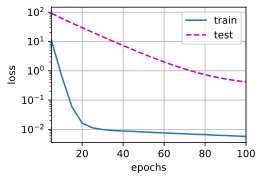

In [118]:
train_concise(3)

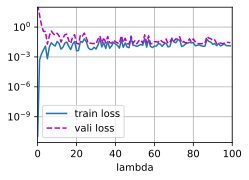

In [123]:

def train_concise_experiment(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
     
    print('w的L2范数：', net[0].weight.norm().item())
    return d2l.evaluate_loss(net, train_iter, loss),d2l.evaluate_loss(net, test_iter, loss)

wds = np.arange(0,100,1)
animator = d2l.Animator(xlabel='lambda', xlim=[0, 100], ylim=[0,1e2],
                        legend=['train loss', 'vali loss'],yscale="log")
for wd in wds:
  train_loss,vali_loss = train_concise_experiment(wd)
  #print(train_loss,vali_loss)
  animator.add(wd, (train_loss,vali_loss))

 
